In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_excel("GSAF5.xls")
pd.set_option("display.max_columns", None)

df['Country'] = df['Country'].str.capitalize()
df['State'] = df['State'].str.capitalize()


In [ ]:
# convert fatal into boolean value

true_vals = {'y', 'y2'}

def to_bool(val):
    if pd.isna(val):
        return False
    val_str = str(val).strip().lower()
    return val_str in true_vals

df["Fatal Y/N Bool"] = df["Fatal Y/N"].apply(to_bool)
print(list(df["Fatal Y/N Bool"].unique()))

df.head()


[np.False_, np.True_]


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22,Fatal Y/N Bool
0,2025-06-17 00:00:00,2025.0,Unprovoked,Usa,South carolina,Hilton Head Island,Swimming,Not stated,F,12,Laceration to lower right leg,N,1200hrs,Not stated,Kevin McMurray Trackingsharks.com:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2025-06-11 00:00:00,2025.0,Unprovoked,Usa,Florida,Boca Grande,Snorkeling,Leah Lendel,F,9,Right hand almost torn off,N,12.11 hrs,Bull shark,Kevin McMurray Trackingsharks.com: James Kings...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2025-05-29 00:00:00,2025.0,Unprovoked,Usa,North carolina,Sunset Beach,Swimming,Sean Barton,M,26,Gash to lower left leg,N,1100hrs,Not stated,Kevin McMurray Trackingsharks.com: Clay Crewel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2025-05-26 00:00:00,2025.0,Unprovoked,Vanuatu,South santo,Espiitu Santo Island,Swimming,Tumas,M,14,Multiple injuries to body one hand and leg bit...,Y,pm,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,2025-05-15 00:00:00,2025.0,Unprovoked,Australia,South australia,Port Noarlunga,Swimming,Richard Vinall,M,66,Injury to thigh,N,0945hrs,Not stated,Simon DeMarchi: Todd Smith: 9 News:ABC News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
# format sex
df["Sex"].unique()

array(['F', 'M', 'F ', 'M ', nan, ' M', 'm', 'lli', 'M x 2', 'N', '.'],
      dtype=object)

In [ ]:
import numpy as np
import re
from datetime import datetime

## parse Time

def clean_and_parse_time(value):
    if pd.isna(value):
        return np.nan

    value = str(value).strip().lower()

    vague_terms = {
        "morning": "08:00", "early morning": "06:00", "midday": "12:00",
        "afternoon": "15:00", "early afternoon": "13:00", "late afternoon": "17:00",
        "evening": "19:00", "night": "21:00", "dusk": "18:00", "sunset": "18:30",
        "am": "08:00", "pm": "14:00", "a.m.": "08:00", "p.m.": "14:00",
        "not stated": np.nan, "not advised": np.nan, "unknown": np.nan, "?": np.nan,
        "shortly before 12h00": "11:55", "before 10h00": "09:55"
    }

    if value in vague_terms:
        value = vague_terms[value]
        if pd.isna(value):
            return np.nan

    # Clean up various suffixes and prefixes
    value = re.sub(r'[^\d:h\.]', '', value)  # Remove non-time characters
    value = re.sub(r'(\d{1,2})hr(\d{2})', r'\1:\2', value)  # e.g., 11hr15 → 11:15
    value = value.replace('h', ':')  # Replace 'h' with ':'
    value = value.replace('.', ':')  # Replace '.' with ':'
    value = re.sub(r':+', ':', value)  # Normalize double colons
    value = value.strip(':')

    # Convert 4-digit numbers like 1300 to 13:00
    if re.match(r'^\d{3,4}$', value):
        value = value.zfill(4)
        value = f"{value[:2]}:{value[2:]}"

    # Final parsing attempt
    try:
        return pd.to_datetime(value, format='%H:%M').time()
    except:
        return np.nan
    
    
df["parsed_time"] = df["Time"].apply(clean_and_parse_time)


In [ ]:
# parse date
def extract_date(raw_date):
    if pd.isna(raw_date):
        return None

    raw = str(raw_date).strip()

    # Try direct parsing for known patterns
    for fmt in ["%d-%b-%Y", "%d-%m-%Y", "%Y-%m-%d", "%d-%b-%y", "%d-%m-%y"]:
        try:
            return pd.to_datetime(raw, format=fmt)
        except:
            continue

    # Try common parsing
    try:
        return pd.to_datetime(raw)
    except:
        pass

    # Try to extract a 4-digit year (priority for earliest)
    match = re.search(r'(\d{4})', raw)
    if match:
        try:
            return pd.to_datetime(match.group(1), format="%Y")
        except:
            return None

    # Try 3-digit BC/AD years, if present
    match = re.search(r'(\d{1,4})\s?(BC|B\.C\.|B\.C|BCE)', raw, re.IGNORECASE)
    if match:
        year = int(match.group(1))
        return pd.to_datetime(f"-{year:04d}", errors='coerce')  # Negative years = BCE

    return None  # Return None if all else fails


df["parsed_date"] = df["Date"].apply(extract_date)
df.head()


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22,Fatal Y/N Bool,parsed_time,parsed_date
0,2025-06-17 00:00:00,2025.0,Unprovoked,Usa,South carolina,Hilton Head Island,Swimming,Not stated,F,12,Laceration to lower right leg,N,1200hrs,Not stated,Kevin McMurray Trackingsharks.com:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,12:00:00,2025-06-17
1,2025-06-11 00:00:00,2025.0,Unprovoked,Usa,Florida,Boca Grande,Snorkeling,Leah Lendel,F,9,Right hand almost torn off,N,12.11 hrs,Bull shark,Kevin McMurray Trackingsharks.com: James Kings...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,12:11:00,2025-06-11
2,2025-05-29 00:00:00,2025.0,Unprovoked,Usa,North carolina,Sunset Beach,Swimming,Sean Barton,M,26,Gash to lower left leg,N,1100hrs,Not stated,Kevin McMurray Trackingsharks.com: Clay Crewel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,11:00:00,2025-05-29
3,2025-05-26 00:00:00,2025.0,Unprovoked,Vanuatu,South santo,Espiitu Santo Island,Swimming,Tumas,M,14,Multiple injuries to body one hand and leg bit...,Y,pm,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,14:00:00,2025-05-26
4,2025-05-15 00:00:00,2025.0,Unprovoked,Australia,South australia,Port Noarlunga,Swimming,Richard Vinall,M,66,Injury to thigh,N,0945hrs,Not stated,Simon DeMarchi: Todd Smith: 9 News:ABC News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,09:45:00,2025-05-15


In [7]:
# clean Gender

df["Sex"] = df.Sex.str.lower()

# 1. Strip spaces and lowercase:
df["Sex"] = df["Sex"].str.strip().str.lower()
# replace values
df["Sex"] = df["Sex"].replace({"f": "F", "m": "M"})
# Remove (or set as NaN) all values not "M" or "F":
df = df[df["Sex"].isin(["M", "F"])]

df.Sex.unique()

array(['F', 'M'], dtype=object)

In [ ]:
# Formatted Year
df['Year'] = df['Year'].fillna(0).astype(int)

In [ ]:
# drop unnecessary columns
df.drop(["Unnamed: 22", "Unnamed: 21", "Case Number", "Case Number.1", "href", "href formula", "pdf", "original order"], axis=1, inplace=True)

In [10]:
# drop parsed columns that got a new name
df.drop(["Date", "Time"], axis=1, inplace=True)
df = df.drop(columns=['Fatal Y/N'])

In [ ]:
df.head()

df['month'] = df['parsed_date'].dt.month

monthly_attack_count = df.groupby(["month"])["Type"].count()
monthly_attack_count

month
1.0     1437
2.0      348
3.0      385
4.0      427
5.0      388
6.0      468
7.0      652
8.0      565
9.0      504
10.0     427
11.0     381
12.0     404
Name: Type, dtype: int64

In [12]:
df['Location'] = (
    df['Location']
    .str.replace(r'70 miles off\s*', '', regex=True)
    .str.replace(r'On the south side of\s*', '', regex=True)
)

In [ ]:
import pandas as pd
import numpy as np
import re

# Step 1: Filter sentence-like or ambiguous entries
def is_species_like(s):
    if not isinstance(s, str):
        return False
    s = s.strip()
    words = s.split()
    # Remove entries with >3 words or descriptive/ambiguous keywords
    if len(words) > 3:
        return False
    lower = s.lower()
    if any(kw in lower for kw in [
        'described', 'reported', 'involv', 'area has',
        'estimated', 'specified', 'unknown', 'not stated',
        'questionable', 'no shark', 'non shark', 'shark involv', 'shark involvement'
    ]):
        return False
    return True
df['Filtered_Species'] = df['Species '].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Filtered_Species'] = df['Filtered_Species'].where(df['Filtered_Species'].apply(is_species_like), np.nan)
# Step 2: Standardize shark species
standard_shark_map = {
    r"(great\s*)?white": "Great White Shark",
    r"\bbull\b": "Bull Shark",
    r"\btiger\b|\btiger\s+shark\b": "Tiger Shark",
    r"black\s*tip|blacktip": "Blacktip Shark",
    r"spinner": "Spinner Shark",
    r"sand\s*tiger|sandtiger": "Sandtiger Shark",
    r"short\s*fin\s*mako|mako": "Mako Shark",
    r"hammerhead": "Hammerhead Shark",
    r"nurse\s*shark": "Nurse Shark",
    r"lemon\s*shark": "Lemon Shark",
    r"reef\s*shark": "Reef Shark",
}
def standardize_shark_type(raw_type):
    if pd.isna(raw_type):
        return "Unknown/Unconfirmed"
    raw_type = raw_type.strip().lower()
    for pattern, standard in standard_shark_map.items():
        if re.search(pattern, raw_type):
            return standard
    if "non shark" in raw_type or "no shark" in raw_type:
        return "Non-shark Incident"
    if "unknown" in raw_type or "unconfirmed" in raw_type:
        return "Unknown/Unconfirmed"
    return "Other"
df["Standardized_Species"] = df["Filtered_Species"].apply(standardize_shark_type)
# Optional: Preview result
print(df[["Species ", "Filtered_Species", "Standardized_Species"]].head(25))

                                  Species    Filtered_Species  \
0                               Not stated                NaN   
1                               Bull shark         Bull shark   
2                               Not stated                NaN   
3                               Not stated                NaN   
4                               Not stated                NaN   
5                Small shark 1m (3ft) long                NaN   
6                             Dusky sharks       Dusky sharks   
7                                Not Staed          Not Staed   
8                               Not stated                NaN   
9                               Not stated                NaN   
10                        1.5m Tiger shark   1.5m Tiger shark   
11                       Great White Shark  Great White Shark   
12                              Bull shark         Bull shark   
13                              Not stated                NaN   
14                       

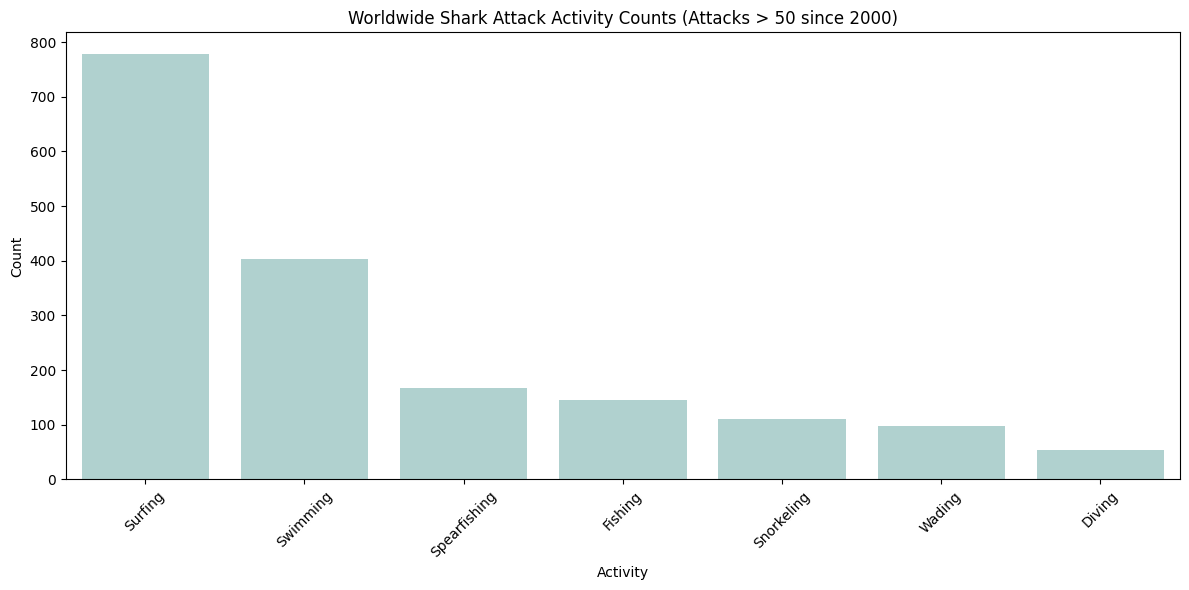

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[df['parsed_date'].dt.year >= 2000]

# Get activity counts
counts = df['Activity'].value_counts()

# Filter activities with counts > 50
activities_over_50 = counts[counts > 50].index

# Filter df to keep only those activities
filtered_activities = df[df['Activity'].isin(activities_over_50)]

grouped_activities = filtered_activities.groupby(["Activity", "Sex", "Age", "Country"])["Type"].count()
# Then get the value counts of these filtered activities (should all be > 50)
result = filtered_activities['Activity'].value_counts().reset_index()
result.columns = ["Activity" , "Count"]

plt.figure(figsize=(12, 6))
sns.barplot(data=result, x='Activity', y='Count', color='#aad7d4')
plt.title('Worldwide Shark Attack Activity Counts (Attacks > 50 since 2000)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

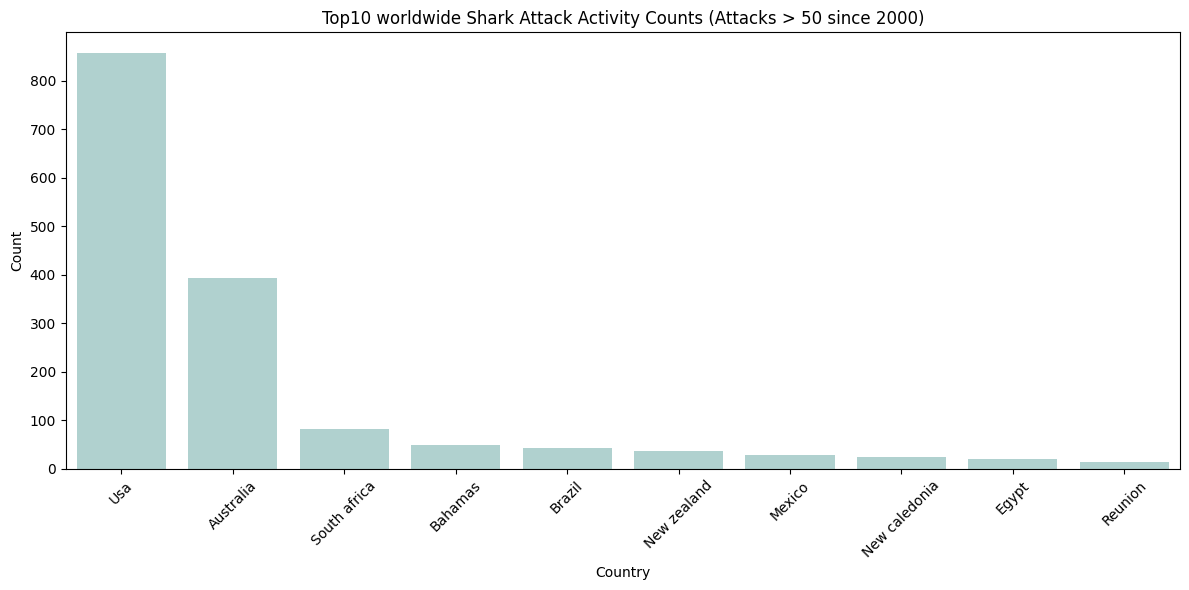

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[df['parsed_date'].dt.year >= 2000]

# Get activity counts
grouped_activities = df.groupby(["Activity", "Sex", "Age", "Country"])["Type"].count()
result = filtered_activities['Country'].value_counts().reset_index()
result.columns = ["Country" , "Count"]
top5_countries = result.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top5_countries, x='Country', y='Count', color='#aad7d4')
plt.title('Top10 worldwide Shark Attack Activity Counts (Attacks > 50 since 2000)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_57184\524998990.py:47: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(data=grouped_activity_state, x='State', y='Count', hue='Activity', palette=custom_palette)


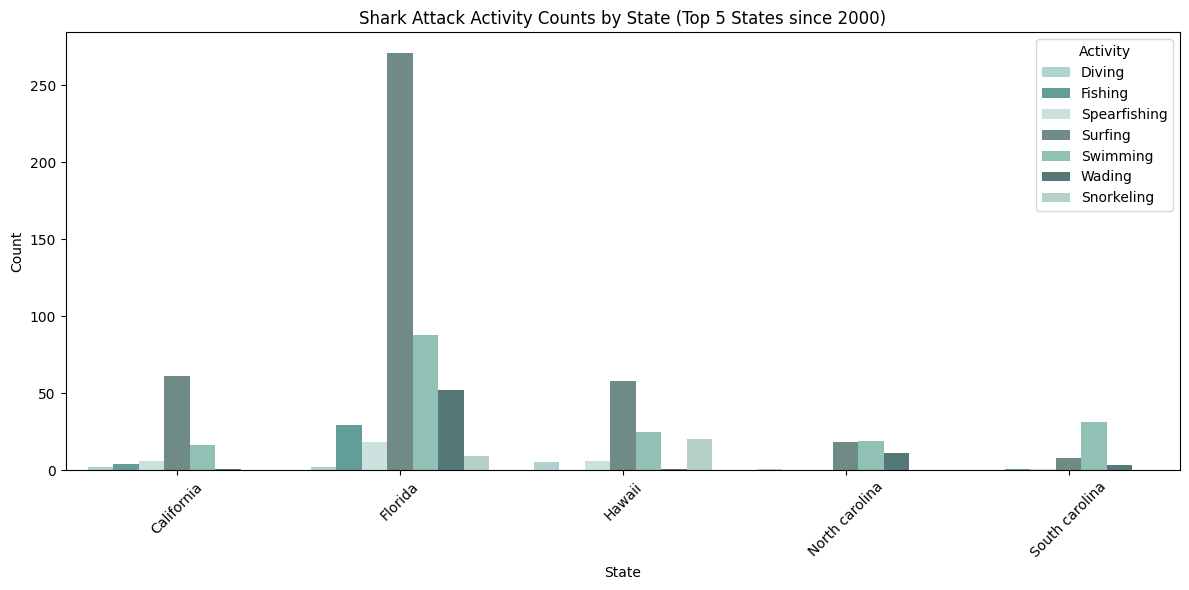

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[df['parsed_date'].dt.year >= 2000]

# Get activity counts
counts = df['Activity'].value_counts()

# Filter activities with counts > 50
activities_over_50 = counts[counts > 50].index

# Filter df to keep only those activities
filtered_activities = df[df['Activity'].isin(activities_over_50)]

grouped_activities = filtered_activities.groupby(["Activity", "Sex", "Age", "Country"])["Type"].count()
# Then get the value counts of these filtered activities (should all be > 50)

usa_only = filtered_activities[filtered_activities['Country'] == "Usa"]

grouped_usa = usa_only.groupby(['State']).size().reset_index(name='Count')

top5 = grouped_usa.sort_values(by='Count', ascending=False).head(5)

filtered_states = usa_only[usa_only['State'].isin(top5['State'])]

grouped_activity_state = filtered_states.groupby(['State', "Activity"]).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12, 6))
custom_palette = [
    '#aad7d4',  # light teal
    '#5aa6a1',  # medium teal
    '#c9e4e2',  # very light teal
    '#6b8e8b',  # muted teal/gray-green
    '#89c9b8',  # soft seafoam green
    '#4f7d7a',  # dark teal-gray
    '#b0d6cc',  # pale mint
    '#497c78',  # deep teal-blue
    '#7fc8b8',  # pastel aquamarine
    '#3b6b68'   # dark muted teal
]
sns.barplot(data=grouped_activity_state, x='State', y='Count', hue='Activity', palette=custom_palette)
plt.title('Shark Attack Activity Counts by State (Top 5 States since 2000)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

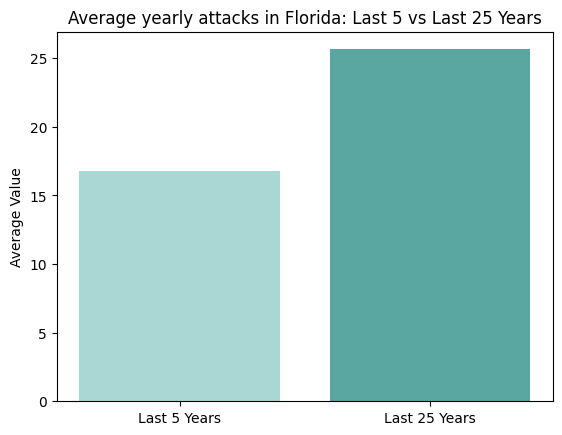

In [18]:
## avg last 5 years vs avg last 25 years in florida

# Filter dataframe for Florida
df_florida = df[df['State'] == 'Florida']

# Get current year or max year in your data
current_year = df_florida['Year'].max()

# Count records per year
yearly_counts = df_florida.groupby('Year').size()
# print(yearly_counts)
# Calculate average counts over last 5 years
avg_last_5_years = yearly_counts[yearly_counts.index > current_year - 5].mean()
# Calculate average counts over last 25 years
avg_last_25_years = yearly_counts[yearly_counts.index > current_year - 25].mean()

# Prepare data for visualization
averages = [avg_last_5_years, avg_last_25_years]
labels = ['Last 5 Years', 'Last 25 Years']

# Plot
plt.bar(labels, averages,  color=['#aad7d4', '#5aa6a1'])
plt.ylabel('Average Value')
plt.title('Average yearly attacks in Florida: Last 5 vs Last 25 Years')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_57184\2524391177.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_florida['Season'] = df_florida['month'].apply(month_to_season)


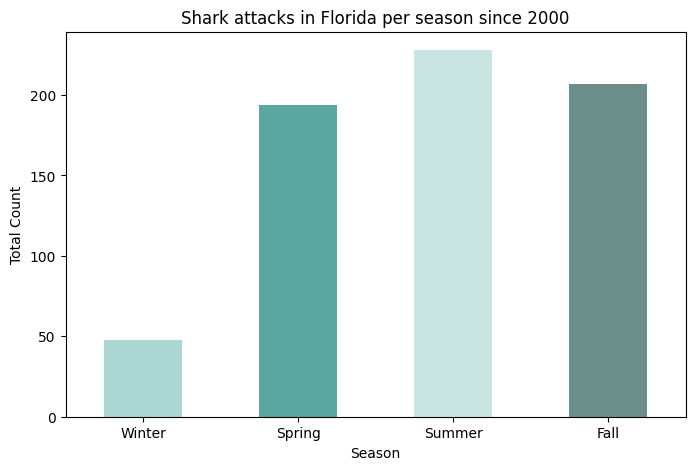

In [ ]:
df = df[df['parsed_date'].dt.year >= 2000]

# Function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
# Filter dataframe for Florida
df_florida = df[df['State'] == 'Florida']    

df_florida['Season'] = df_florida['month'].apply(month_to_season)
# Calculate total count per season
season_counts = df_florida.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Plot bar chart
plt.figure(figsize=(8,5))
season_counts.plot(kind='bar', color=['#aad7d4', '#5aa6a1', '#c9e4e2', '#6b8e8b'])
plt.xlabel('Season')
plt.ylabel('Total Count')
plt.title('Shark attacks in Florida per season since 2000')
plt.xticks(rotation=0)
plt.show()


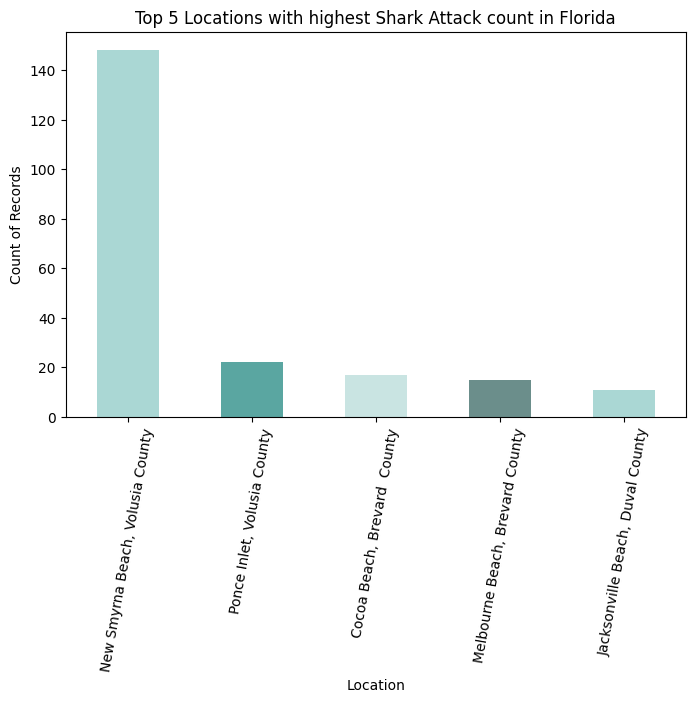

In [20]:
# Filter for Florida
df_florida = df[df['State'] == 'Florida']

# Remove rows with blank or NaN 'Location' in Florida data
df_florida_clean = df_florida[df_florida['Location'].notna() & (df_florida['Location'].str.strip() != '')]

# Get top 5 locations by count
top5_locations = df_florida_clean['Location'].value_counts().head(5).index

# Filter only top 5 locations
df_top5 = df_florida_clean[df_florida_clean['Location'].isin(top5_locations)]

# Count records per location
location_counts = df_top5['Location'].value_counts().loc[top5_locations]

# Plot bar chart
plt.figure(figsize=(8,5))
location_counts.plot(kind='bar', color=['#aad7d4', '#5aa6a1', '#c9e4e2', '#6b8e8b'])
plt.xlabel('Location')
plt.ylabel('Count of Records')
plt.title('Top 5 Locations with highest Shark Attack count in Florida')
plt.xticks(rotation=80)
plt.show()

Index(['Year', 'Type', 'Country', 'State', 'Location', 'Activity', 'Name',
       'Sex', 'Age', 'Injury', 'Species', 'Source', 'Fatal Y/N Bool',
       'parsed_time', 'parsed_date', 'month', 'Filtered_Species',
       'Standardized_Species'],
      dtype='object')


C:\Users\User\AppData\Local\Temp\ipykernel_57184\2311689086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_florida.rename(columns={'Species ': 'Species'}, inplace=True)


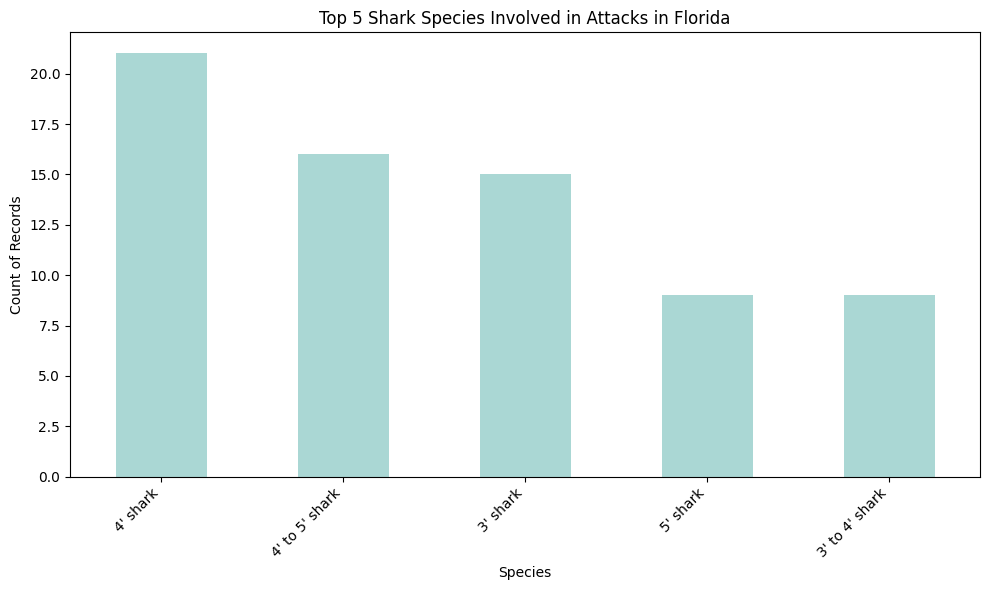

In [21]:
# species that attacks most often in florida
# Filter for Florida
df_florida = df[df['State'] == 'Florida']
df_florida.rename(columns={'Species ': 'Species'}, inplace=True)
print(df_florida.columns)
# Remove rows with blank or NaN 'Species' in Florida data
df_florida_clean = df_florida[df_florida['Species'].notna() & (df_florida['Species'].str.strip() != '')]

df_florida_clean = df_florida_clean[df_florida_clean["Species"] != "Shark involvement not confirmed"]

# Get top 5 species by count
top5_species = df_florida_clean['Species'].value_counts().head(5).index

# Filter only top 5 species
df_top5_species = df_florida_clean[df_florida_clean['Species'].isin(top5_species)]

# Count records per species
species_counts = df_top5_species['Species'].value_counts().loc[top5_species]

# Plot bar chart
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='#aad7d4')
plt.xlabel('Species')
plt.ylabel('Count of Records')
plt.title('Top 5 Shark Species Involved in Attacks in Florida')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
def clean_age(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        return int(value)
    if isinstance(value, str):
        value = value.strip().lower()
        # Remove '+' and 's' from ages like '30+' or '30s'
        value = re.sub(r'[+\']s$', '', value)
        # Replace common age words
        if value in ['teen', 'young', 'adult', 'middle age', 'elderly', 'a.m.', 'm', 'x']:
            return np.nan
        # Handle ranges like "12 or 13", "28 & 22", "30 or 36"
        range_match = re.findall(r'(\d+)', value)
        if range_match:
            # Take average of all numbers found (or first if preferred)
            nums = list(map(int, range_match))
            return int(sum(nums) / len(nums))
        # Handle >50 or similar
        if value.startswith('>'):
            try:
                return int(value[1:])
            except:
                return np.nan
        # Handle single number strings
        if value.isdigit():
            return int(value)
        # Remove any non-digit characters
        digits = re.findall(r'\d+', value)
        if digits:
            return int(digits[0])
    return np.nan

df["cleaned_Age"] = df["Age"].apply(clean_age)
print(list(df["cleaned_Age"].unique()))

df.head()

[np.float64(12.0), np.float64(9.0), np.float64(26.0), np.float64(14.0), np.float64(66.0), np.float64(45.0), np.float64(20.0), np.float64(30.0), np.float64(nan), np.float64(37.0), np.float64(56.0), np.float64(40.0), np.float64(29.0), np.float64(35.0), np.float64(58.0), np.float64(24.0), np.float64(55.0), np.float64(17.0), np.float64(36.0), np.float64(23.0), np.float64(28.0), np.float64(69.0), np.float64(48.0), np.float64(60.0), np.float64(57.0), np.float64(61.0), np.float64(27.0), np.float64(38.0), np.float64(16.0), np.float64(68.0), np.float64(33.0), np.float64(15.0), np.float64(41.0), np.float64(18.0), np.float64(21.0), np.float64(49.0), np.float64(25.0), np.float64(46.0), np.float64(19.0), np.float64(65.0), np.float64(64.0), np.float64(13.0), np.float64(11.0), np.float64(32.0), np.float64(10.0), np.float64(62.0), np.float64(39.0), np.float64(22.0), np.float64(52.0), np.float64(44.0), np.float64(47.0), np.float64(59.0), np.float64(8.0), np.float64(50.0), np.float64(34.0), np.float64(7

,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Species,Source,Fatal Y/N Bool,parsed_time,parsed_date,month,Filtered_Species,Standardized_Species,cleaned_Age
0,2025,Unprovoked,Usa,South carolina,Hilton Head Island,Swimming,Not stated,F,12,Laceration to lower right leg,Not stated,Kevin McMurray Trackingsharks.com:,False,12:00:00,2025-06-17,6.0,NaN,Unknown/Unconfirmed,12.0
1,2025,Unprovoked,Usa,Florida,Boca Grande,Snorkeling,Leah Lendel,F,9,Right hand almost torn off,Bull shark,Kevin McMurray Trackingsharks.com: James Kings...,False,12:11:00,2025-06-11,6.0,Bull shark,Bull Shark,9.0
2,2025,Unprovoked,Usa,North carolina,Sunset Beach,Swimming,Sean Barton,M,26,Gash to lower left leg,Not stated,Kevin McMurray Trackingsharks.com: Clay Crewel...,False,11:00:00,2025-05-29,5.0,NaN,Unknown/Unconfirmed,26.0
3,2025,Unprovoked,Vanuatu,South santo,Espiitu Santo Island,Swimming,Tumas,M,14,Multiple injuries to body one hand and leg bit...,Not stated,Kevin McMurray Trackingsharks.com,True,14:00:00,2025-05-26,5.0,NaN,Unknown/Unconfirmed,14.0
4,2025,Unprovoked,Australia,South australia,Port Noarlunga,Swimming,Richard Vinall,M,66,Injury to thigh,Not stated,Simon DeMarchi: Todd Smith: 9 News:ABC News,False,09:45:00,2025-05-15,5.0,NaN,Unknown/Unconfirmed,66.0


In [23]:
bins = [0, 12, 18, 30, 50, 65, 100]  # example bins
labels = ['Child (0-12)', 'Teen (13-18)', 'Young Adult (19-30)', 'Adult (31-50)', 'Senior (51-65)', 'Elderly (65+)']
# Bin the ages

df['Age_Group'] = pd.cut(df['cleaned_Age'], bins=bins, labels=labels, right=True)

df.head()

,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Species,Source,Fatal Y/N Bool,parsed_time,parsed_date,month,Filtered_Species,Standardized_Species,cleaned_Age,Age_Group
0,2025,Unprovoked,Usa,South carolina,Hilton Head Island,Swimming,Not stated,F,12,Laceration to lower right leg,Not stated,Kevin McMurray Trackingsharks.com:,False,12:00:00,2025-06-17,6.0,NaN,Unknown/Unconfirmed,12.0,Child (0-12)
1,2025,Unprovoked,Usa,Florida,Boca Grande,Snorkeling,Leah Lendel,F,9,Right hand almost torn off,Bull shark,Kevin McMurray Trackingsharks.com: James Kings...,False,12:11:00,2025-06-11,6.0,Bull shark,Bull Shark,9.0,Child (0-12)
2,2025,Unprovoked,Usa,North carolina,Sunset Beach,Swimming,Sean Barton,M,26,Gash to lower left leg,Not stated,Kevin McMurray Trackingsharks.com: Clay Crewel...,False,11:00:00,2025-05-29,5.0,NaN,Unknown/Unconfirmed,26.0,Young Adult (19-30)
3,2025,Unprovoked,Vanuatu,South santo,Espiitu Santo Island,Swimming,Tumas,M,14,Multiple injuries to body one hand and leg bit...,Not stated,Kevin McMurray Trackingsharks.com,True,14:00:00,2025-05-26,5.0,NaN,Unknown/Unconfirmed,14.0,Teen (13-18)
4,2025,Unprovoked,Australia,South australia,Port Noarlunga,Swimming,Richard Vinall,M,66,Injury to thigh,Not stated,Simon DeMarchi: Todd Smith: 9 News:ABC News,False,09:45:00,2025-05-15,5.0,NaN,Unknown/Unconfirmed,66.0,Elderly (65+)


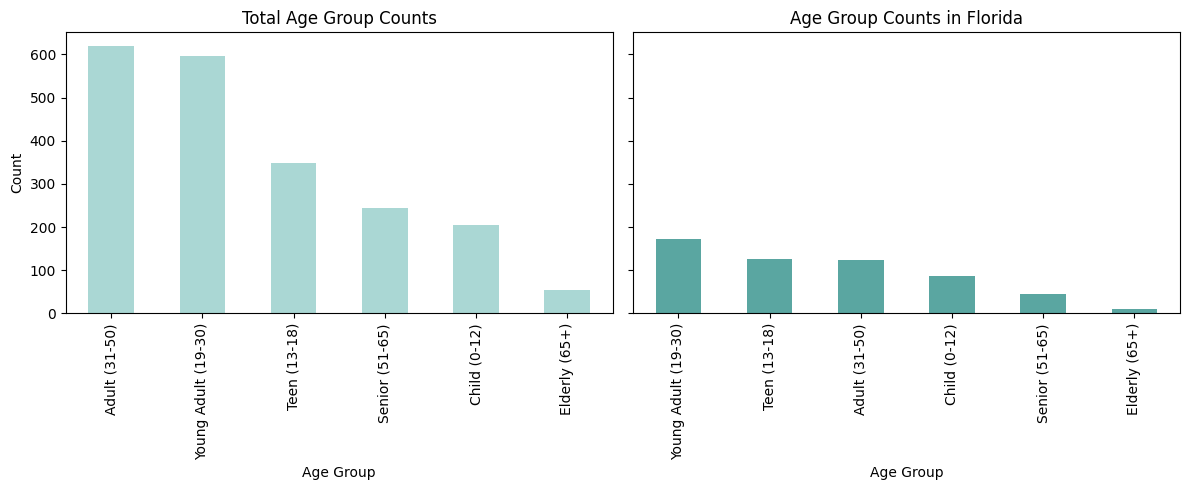

In [ ]:
# Total counts
total_counts = df['Age_Group'].value_counts()

# Filtered counts for Florida
florida_counts = df[df['State'] == 'Florida']['Age_Group'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot total counts
total_counts.plot(kind='bar', ax=axes[0], color='#aad7d4')
axes[0].set_title('Total Age Group Counts')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')

# Plot Florida counts
florida_counts.plot(kind='bar', ax=axes[1], color='#5aa6a1')
axes[1].set_title('Age Group Counts in Florida')
axes[1].set_xlabel('Age Group')

plt.tight_layout()
plt.show()